# EMG Pipeline #

This notebook is to demonstrate the pipeline for EMG source inversion.

# Imports #
These should be covered in `requirements.txt`- activate the virtual environment `.venv` for the Python kernel and then make sure that environment has installed `pip install -r requirements.txt`. 

In [1]:
from scipy.constants import epsilon_0
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import kv as K0, iv as I0
from scipy.linalg import solve, pinv, svd

from EMGinv_fns import *

from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull, Delaunay
from scipy.optimize import minimize

import pandas as pd
import scipy.io
import mat73
from pathlib import Path
import shutil
import os.path as op
import mne

import gc
import matplotlib.animation as animation
import pydicom

# Remove magic commands if turning into a script
import pyvistaqt
# %matplotlib qt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Loading source space and forward model generated in MNE-python, see Fwd_BEM_MNE.ipynb

# Load electrode positions
electrode_pos = np.load('Data/256simparm_electrode_pos.npy')

# Load forward model
mne_fwd = mne.read_forward_solution('Data/simp_arm_2mm-fwd.fif')
fwd = mne_fwd['sol']['data']
pos = mne_fwd['source_rr'] 

xscaling, yscaling, zscaling = (2e-3, 2e-3, 2e-3) # Is the distance between dipoles in source space #np.repeat(np.abs(np.sum(np.diff(pos[0], axis = 0))),3)  

# Transformations specific to dataset
# Need to remove some electrodes - get rid of the middle ones
fwd = np.vstack((fwd[:64,:], fwd[192:,:]))
electrode_pos = np.vstack((electrode_pos[:64,:], electrode_pos[192:,:]))

# If Blender defaults were used may need to adjust axes = ["X", "Z", "Y"], however this should not be necessary otherwise
# electrode_pos = electrode_pos[:,[0,2,1]] , # pos = pos[:,[0,2,1]]

# Removal of dipole sources - here remove sources lying within cylinders representing bone
pos, fwd = bone_remover(pos, fwd, -9e-3, 0, 5e-3) #Ulnar
pos, fwd = bone_remover(pos, fwd, 5e-3, -9e-3, 5e-3) # Radius

# Consider fwd model adjustments
# Condense the fwd such that there is only one dipole per voxel
dipole_ori = [0, 0, 1]
fwd = fwd_convertfixed(fwd, dipole_ori )

Reading forward solution from c:\MyRepos\Python\CMU_EMGSL\Data\simp_arm_2mm-fwd.fif...
    Reading a source space...
    [done]
    1 source spaces read
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read EEG forward solution (23424 sources, 256 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame


In [3]:
fwd.shape

(128, 20654)

In [30]:
# Alternative: Loading source space and forward model generated from (MRI) image data
# # Load electrode positions
# electrode_pos = np.load('electrode_pos.npy')

# # Load source space 
# xscaling, yscaling, zscaling = 1.5e-4, 1.5e-4, 0.5e-2
# pos = load_src_template(filename=None, xscaling=xscaling, yscaling=yscaling, zscaling=zscaling)

# # Load forward model
# fwd = np.load('Data/fwd_dipole.npy')
# # Alternative would be to generate with
# # fwd = fwd_generator(dipole_potential, pos, electrode_positions)
# # And then saving with np.save('fwd_dipole.npy', fwd) - Very big file

# # Consider fwd model adjustments
# # Condense the fwd such that there is only one dipole per voxel
# dipole_ori = [0, 0, 1]
# fwd = fwd_convertfixed(fwd, dipole_ori )

# # Adjust the fwd to remove some outliers
# # fwd[fwd>1e15] = 1e15
# # fwd = np.log10(fwd+1)  # this doesn't preserve sign
# fwd[np.isnan(fwd)] = 0 # for any nans

In [4]:
# Load muap template waveforms 
# filename = '/Users/pokhims/Library/CloudStorage/OneDrive-TheUniversityofMelbourne/Documents/Coding/CMU_EMGSL/Data/muaps_frommatlab.mat'
# muaps_1 = scipy.io.loadmat(filename)['muaps']

# Load some data - to construct covariance matrices
# MNE_raw = load_tmsitomne_combine(f_prox = 'Data/Pok_2024_08_21_A_PROX_8.poly5', f_dist='Data/Pok_2024_08_21_B_DIST_8.poly5', scale=1e-6)
MNE_raw = load_tmsitomne_combine(f_prox = 'C:/Data/MetaWB/MCP04_2024_09_17/TMSi/MCP04_2024_09_17_A_PROX_3.poly5', 
                                 f_dist='C:/Data/MetaWB/MCP04_2024_09_17/TMSi/MCP04_2024_09_17_B_DIST_3.poly5', 
                                 scale=1e-6, 
                                 trigger_bit = 1)

Reading file  C:/Data/MetaWB/MCP04_2024_09_17/TMSi/MCP04_2024_09_17_A_PROX_3.poly5
	 Number of samples:  492687 
	 Number of channels:  70 
	 Sample rate: 2000 Hz
Done reading data.
Creating RawArray with float64 data, n_channels=70, n_times=492687
    Range : 0 ... 492686 =      0.000 ...   246.343 secs
Ready.
Sample rate:  2000  Hz
Channel names:  ['UNI 01', 'UNI 02', 'UNI 03', 'UNI 04', 'UNI 05', 'UNI 06', 'UNI 07', 'UNI 08', 'UNI 09', 'UNI 10', 'UNI 11', 'UNI 12', 'UNI 13', 'UNI 14', 'UNI 15', 'UNI 16', 'UNI 17', 'UNI 18', 'UNI 19', 'UNI 20', 'UNI 21', 'UNI 22', 'UNI 23', 'UNI 24', 'UNI 25', 'UNI 26', 'UNI 27', 'UNI 28', 'UNI 29', 'UNI 30', 'UNI 31', 'UNI 32', 'UNI 33', 'UNI 34', 'UNI 35', 'UNI 36', 'UNI 37', 'UNI 38', 'UNI 39', 'UNI 40', 'UNI 41', 'UNI 42', 'UNI 43', 'UNI 44', 'UNI 45', 'UNI 46', 'UNI 47', 'UNI 48', 'UNI 49', 'UNI 50', 'UNI 51', 'UNI 52', 'UNI 53', 'UNI 54', 'UNI 55', 'UNI 56', 'UNI 57', 'UNI 58', 'UNI 59', 'UNI 60', 'UNI 61', 'UNI 62', 'UNI 63', 'UNI 64', 'AUX 1-

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 100.00
- Lower transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 87.50 Hz)
- Filter length: 265 samples (0.133 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.6s


[[ 19788      0      0]
 [ 39739      0      1]
 [ 49789      0      0]
 [ 69739      0      1]
 [ 79789      0      0]
 [ 99739      0      1]
 [109789      0      0]
 [129769      0      1]
 [139790      0      0]
 [159770      0      1]
 [169820      0      0]
 [189800      0      1]
 [199850      0      0]
 [219800      0      1]
 [229850      0      0]
 [249831      0      1]
 [259851      0      0]
 [279831      0      1]
 [289851      0      0]
 [309831      0      1]
 [319851      0      0]
 [339861      0      1]
 [349882      0      0]
 [369862      0      1]
 [379882      0      0]
 [399862      0      1]
 [409882      0      0]
 [429892      0      1]
 [439912      0      0]
 [459893      0      1]]
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 30 events and 16001 original time points ...
0 bad epochs dropped
    Setting small EEG eigenvalues to zero (without PCA)
Reducing data ran

C:\Users\maxmu\AppData\Local\Temp\ipykernel_96420\4215531110.py:16: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  noise_cov = mne.compute_covariance(epochs, method='auto', tmin=-2, tmax=0.01)


Done.
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
    EEG regularization : 0.1
    EEG regularization : 0.1
    EEG regularization : 0.1
Number of samples used : 120630
log-likelihood on unseen data (descending order):
   empirical: -294.105
   shrunk: -294.529
   diagonal_fixed: -306.279
selecting best estimator: empirical
[done]
    Setting small EEG eigenvalues to zero (without PCA)
Reducing data rank from 128 -> 126
Estimating covariance using SHRUNK


C:\Users\maxmu\AppData\Local\Temp\ipykernel_96420\4215531110.py:17: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  data_cov = mne.compute_covariance(epochs, method='auto', tmin=1, tmax=epochs.tmax)


Done.
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
    EEG regularization : 0.1
    EEG regularization : 0.1
    EEG regularization : 0.1
Number of samples used : 180030
log-likelihood on unseen data (descending order):
   empirical: -356.992
   shrunk: -357.687
   diagonal_fixed: -372.832
selecting best estimator: empirical
[done]
Computing rank from covariance with rank=None
    Using tolerance 4.5e-13 (2.2e-16 eps * 128 dim * 16  max singular value)
    Estimated rank (eeg): 126
    EEG: rank 126 computed from 128 data channels with 0 projectors


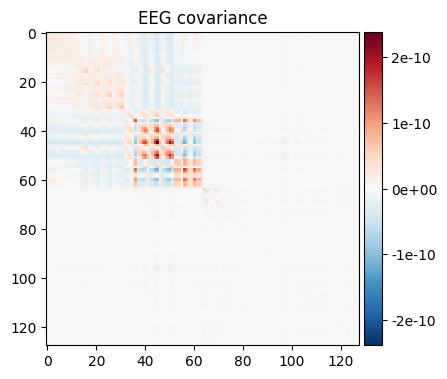

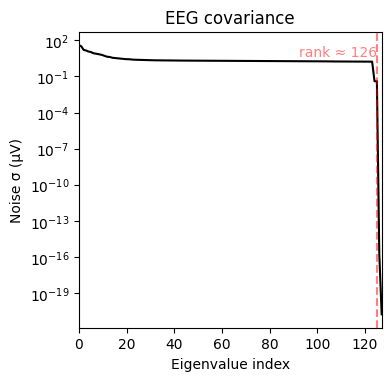

Computing rank from covariance with rank=None
    Using tolerance 8.7e-13 (2.2e-16 eps * 128 dim * 31  max singular value)
    Estimated rank (eeg): 126
    EEG: rank 126 computed from 128 data channels with 0 projectors


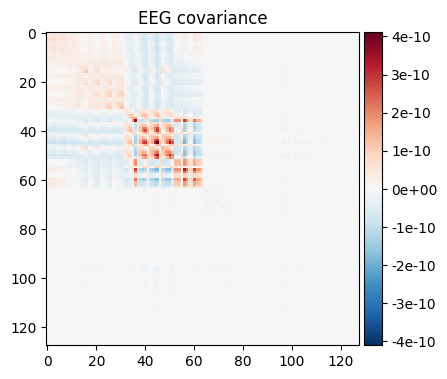

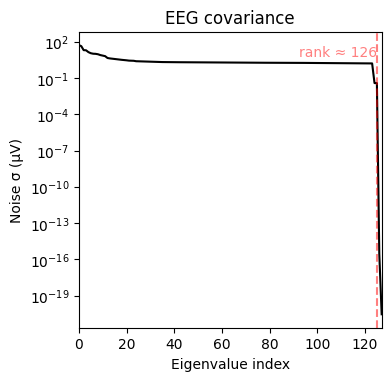

In [5]:
# Important to filter the data (highpass filter)
MNE_raw = MNE_raw.filter(l_freq=100, h_freq=None, )
# Estimate the noise covariance matrix on Epoched data.  This means that the noise covariance will be estimated on pre-stimulus periods
# events = tmsi_eventextractor(MNE_raw['Prox - TRIGGERS'][0][0] - 252) # Pok data
events = tmsi_ttl_eventextractor(MNE_raw['Prox - TRIGGERS'][0][0], trigger_bit=1) 
print(events)
# event_dict = {'Ext': -2, 'Flex': -6} # Should be correct 
event_dict = {'Rest': 0, 'Go': 1} # MCP04 data
epochs = mne.Epochs(MNE_raw, events, event_dict, tmin=-4, tmax=4, baseline=None, preload=True)
# Consider setting an average EEG reference across each panel of 32. 
# epochs.set_eeg_reference('average', projection=True)
# epochs.apply_proj()
# epochs.plot(n_epochs=1, scalings='auto', );

# Set tmin and tmax based on experimental conditions.  In this case, the participant was not moving perfectly to the triggers.
noise_cov = mne.compute_covariance(epochs, method='auto', tmin=-2, tmax=0.01)
data_cov = mne.compute_covariance(epochs, method='auto', tmin=1, tmax=epochs.tmax)

noise_cov.plot(epochs.info,);
data_cov.plot(epochs.info,);

# Alternative to muaps_from matlab.mat - Load the mask, and then extract from the relevant EMG channels in MNE_raw
# filename = '/Users/pokhims/Library/CloudStorage/OneDrive-TheUniversityofMelbourne/Documents/Coding/CMU_EMGSL/Data/muaps_mask.mat'
filename = 'Data/MCP04_2024_09_17_A_PROX_3_muaps_mask.mat'
mask = scipy.io.loadmat(filename)['mask']
# Not sure why some of the masks aren't in the data - and why the end result is so different
mask = mask[:-2, :]
data = MNE_raw.get_data(picks='data')
# Need to get component for all channels
muaps = np.zeros((128,41))
for i in range(128):
    tmp = data[i,:]
    snips = tmp[mask]
    muaps[i,:] = np.mean(snips, axis=0)

# Another alternative to the data
ext_1 = epochs.get_data(picks='data')[0,:,10:50]
flex_1 = epochs.get_data(picks='data')[0,:,10:50]

In [6]:
# epochs.plot(n_epochs=1, scalings='auto',);

In [7]:
del MNE_raw, epochs, data, tmp, snips

gc.collect()

20214

In [8]:
# Beamformer - for online processing - Note max_power is only for use when dipole orientation is unknown

w_lcmv = lcmv_beamformer_constructor(fwd, data_cov=data_cov.data, noise_cov= noise_cov.data, pos=pos, arr_gain=True, max_power=False)

print(sys.getsizeof(w_lcmv)/8/1024/1024, 'MB')

2.8459625244140625 MB


In [9]:
# Choose the waveform to use - muaps, ext_1, flex_1
waveform = ext_1

# Apply beamformer
source_activity_time = np.dot(w_lcmv, waveform)

print(sys.getsizeof(source_activity_time)/8/1024/1024, 'MB')

0.889373779296875 MB


In [10]:
# Alternative algorithms, can consider looking at minimum norm estimate:

# Minimum norm estimate
# source_activity_time = minimum_norm_estimate(fwd, waveform, noise_cov=noise_cov.data, reg=0.1)

# sLoreta
# source_activity_time = sloreta(fwd[:N,:], waveform, noise_cov=noise_cov, reg=0.1)

# Different optimisers for ECD (Equivalent Current Dipole) fitting - Which did not work too well
# n_dipoles = 1
# data = muaps[:, 20]
# N=data.shape[0]
# optimal_dipoles = ECD_fit_dipoles(data, fwd[:N,:]/np.linalg.norm(fwd[:N,:]), pos, n_dipoles, initial_guess=np.array([0.05, 0.09, 0.03, 1, 1, 1]), local=True) # 
# optimal_dipoles = ECD_fit_dipoles_analytical(data, electrode_pos[:N,:], n_dipoles, local=True)
# print("Optimal dipole parameters (position, strengths):", optimal_dipoles)

# Best dipole in fwd
# best_index, best_weights, save_arr = best_dipole_infwd(fwd, muaps)
# Pos as obtained from:
# pos[best_index[t],0], pos[best_index[t],1], pos[best_index[t],2]

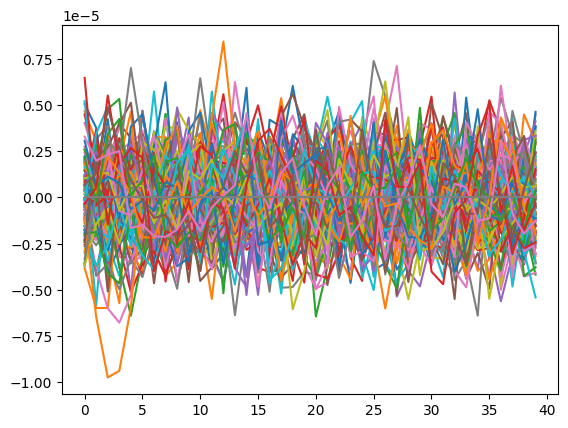

In [11]:
plt.figure()
plt.plot(waveform.T);

# Visualisations

Text(0.5, 0, 'Z Axis (m)')

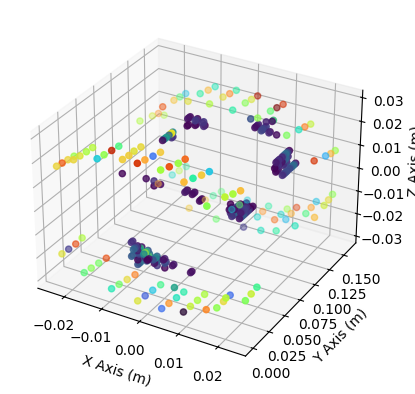

In [12]:
# Threshold
thresh = 0.5
# Look at specific timepoint in the source activity - 20 for matlab template waveform, 30 for other one; ext_1 - 5s and 15s are interesting; flex_1 - 9s
t = 15

source_activity = source_activity_time[:, t]

# Reshape source activity to condense N source orientations into 1 per voxel - Confirmed works for 3 orientations, should work for more.
reshape_by = source_activity.shape[0] // pos.shape[0]
reshaped_act = np.array(source_activity.reshape((reshape_by, -1), order='F'))
source_activity = np.linalg.norm(reshaped_act, axis=0)

ind = np.abs(source_activity) > thresh*np.max(np.abs(source_activity))
source_activity = source_activity[ind]
pos_t = pos[ind]

# Plot the convex hull and the moved points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Plot electrode positions
ax.scatter(electrode_pos[:, 0], electrode_pos[:, 1], electrode_pos[:, 2], c=waveform[:,t], marker='o', cmap='turbo')
# Plot the source space
ax.scatter(pos_t[:, 0], pos_t[:, 1], pos_t[:, 2], c=source_activity, marker='o', alpha=0.8, cmap='viridis')
# Set labels
ax.set_xlabel('X Axis (m)')
ax.set_ylabel('Y Axis (m)')
ax.set_zlabel('Z Axis (m)')


Palm-side in this plot is `-z` axis. Electrode rings are oriented in the `xy` plane, with `y` displaying proximal to distal.

In [13]:
source_activity = source_activity_time[:, t]

# Faster to reconfigure the scatter points to be in a grid, and then use imshow to plot the activity.
grid = pos_to_3Dgrid_converter(pos, source_activity, (xscaling, yscaling, zscaling))

x_min, x_max = np.min(pos[:, 0]), np.max(pos[:, 0])
y_min, y_max = np.min(pos[:, 1]), np.max(pos[:, 1])
z_min, z_max = np.min(pos[:, 2]), np.max(pos[:, 2])

In [14]:
grid.shape

(19, 82, 19)

In [15]:
# ARM_DICOM_FILENAME = '/Users/pokhims/Library/CloudStorage/OneDrive-TheUniversityofMelbourne/Documents/Coding/CMU_EMGSL/Data/R_Forearm.dcm'
ARM_DICOM_FILENAME = 'Data/R_Forearm.dcm'
# Load arm MRI file
ds = pydicom.dcmread(ARM_DICOM_FILENAME)
arm_image = ds.pixel_array
arm_image.shape

(26, 573, 969, 3)

MRI for visualisation and does not represent patient nor model arm


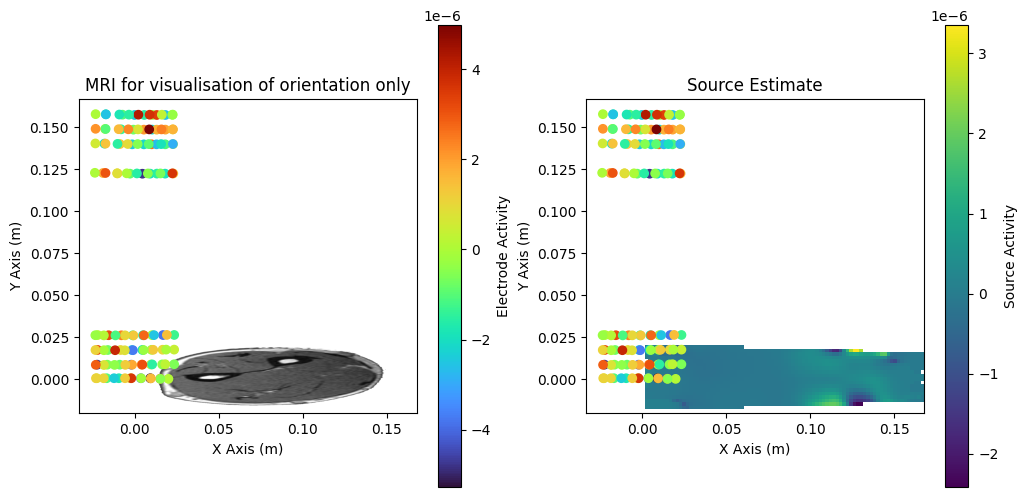

In [16]:
# Plot a slice of the source estimate
z = 10

# Display the source estimate and an arm for reference
plt.figure(figsize=(12, 6))

plt.subplot(121) 
plt.imshow(arm_image[z*arm_image.shape[0]//grid.shape[2], 100:500 , 330:670 , 2], extent=[y_min, y_max, x_min, x_max], cmap='gray', origin='upper')
plt.title('MRI for visualisation of orientation only'), plt.axis('on')
print('MRI for visualisation, does not represent patient nor model arm and needs to be flipped betwen left and right arm.')
plt.scatter(electrode_pos[:, 0], electrode_pos[:, 1], c=waveform[:,t], cmap='turbo', marker='o',)
plt.colorbar(label='Electrode Activity')
plt.xlabel('X Axis (m)'), plt.ylabel('Y Axis (m)')

plt.subplot(122)
plt.imshow(grid[:,:,z], extent=[y_min, y_max, x_min, x_max], origin='upper', cmap='viridis')
plt.colorbar(label='Source Activity')
plt.scatter(electrode_pos[:, 0], electrode_pos[:, 1], c=waveform[:,t], cmap='turbo',marker='o',)
plt.xlabel('X Axis (m)'), plt.ylabel('Y Axis (m)')

plt.title('Source Estimate'), plt.axis('on')
plt.show()

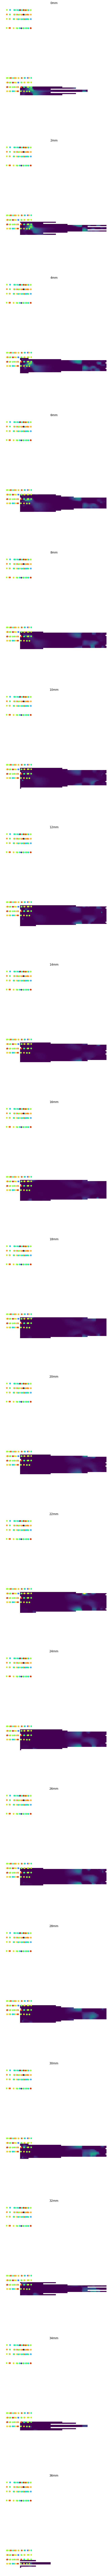

In [42]:
# Plot all the slices
# This is hard to use when there are too many slices!  May need to change the matplotlib viewer if too many slices
# %matplotlib inline

num_slices = grid.shape[2]

# Create subplots
fig, axes = plt.subplots(num_slices, 1, figsize=(8, 200))

# Plot each slice
for z in range(num_slices):
    # Plot activity
    axes[z].imshow(grid[:,:,z], extent=[y_min, y_max, x_min, x_max], origin='upper', cmap='viridis', vmin=0, vmax=np.nanmax(grid) )
    # Plot electrode position
    axes[z].scatter(electrode_pos[:, 0], electrode_pos[:, 1], c=waveform[:,t], cmap='turbo', marker='o')
    axes[z].set_title(f'{int(1000*z*zscaling)}mm')
    axes[z].axis('off')

# fig.colorbar(axes[0].imshow(labels[:, :, 0], cmap='viridis'), ax=axes, orientation='vertical')

# Display the plot
# plt.tight_layout()
plt.show()

In [43]:
# # If want to do 3D animated plot

# def update_plot(i, data, scat, ):
#     scat.set_array(data[i])
#     ax.set_title(f'Timepoint {i}')
#     return scat,

# numframes = muaps.shape[1]
# colour_data = muaps.T
# pos_move = pos[best_index,:]

# # Plot 3D image of electrode positions and select dipole positions

# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(111, projection='3d')

# # Plot the electrode positions
# p = ax.scatter(electrode_pos[:, 0], electrode_pos[:, 1], electrode_pos[:, 2], c=muaps[:,0], marker='o', ) #vmin=muaps.min(), vmax=muaps.max())
# # fig.colorbar(p, ax=ax)
# # Colourbar and vmin and vmax may not be useful as only one electrode may seem to change colour
# # p2 = ax.scatter(pos[best_index[:],0], pos[best_index[:],1], pos[best_index[:],2], c='r', marker='x', s=50, )

# # Set labels
# ax.set_xlabel('X (m)')
# ax.set_ylabel('Y (m)')
# ax.set_zlabel('Z (m)')

# ani = animation.FuncAnimation(fig, update_plot, frames=range(numframes),
#                                 fargs=(colour_data, p, ))
# plt.show()